In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns

In [2]:
from ercopt import Optimizer
from ercs import comm_erc
from problem import styblinski

In [3]:
# Select the problem
func = styblinski

# Store the results for all runs
all_results = []

# Number of runs
num_runs = 5

# Number of evaluations
n_iter = 100

# Perform the optimization
for i in range(num_runs):
    # Initialize commitment constraint
    erc = comm_erc(p=func, epoch=12, order=2, seed=i)
    
    # Initialize optimizer
    opt = Optimizer(erc=erc, strategy="commitment",
                    dimensions=func.bounds,
                    base_estimator="GP", acq_func="EI", acq_optimizer="lbfgs", random_state=i)    

    # Optimization loop
    for i in range(100):
        suggested = opt.ask()
        y = styblinski([suggested])
        opt.tell(suggested, y)
    
    # Save result object
    all_results.append(opt.get_result())

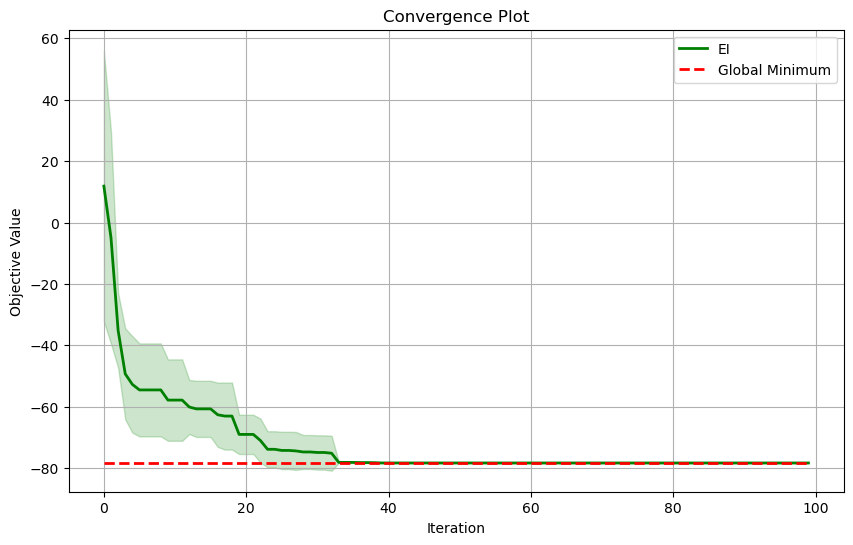

In [4]:
# Compute the average and standard deviation of minimum function value at each step
avg_min_vals = np.mean([np.minimum.accumulate(res.func_vals) for res in all_results], axis=0)
std_min_vals = np.std([np.minimum.accumulate(res.func_vals) for res in all_results], axis=0)

# Generate the convergence plot
plt.figure(figsize=(10, 6))

plt.plot(avg_min_vals, 'g-', linewidth=2.0, label='EI')
plt.fill_between(range(n_iter), avg_min_vals-std_min_vals, avg_min_vals+std_min_vals, color='g', alpha=0.2)

# Global minimum for Styblinski function
global_minimum = -39.16599 * 2
plt.plot([global_minimum]*n_iter, 'r--', linewidth=2.0, label='Global Minimum')

plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Convergence Plot')
plt.legend()
plt.grid()
plt.show()

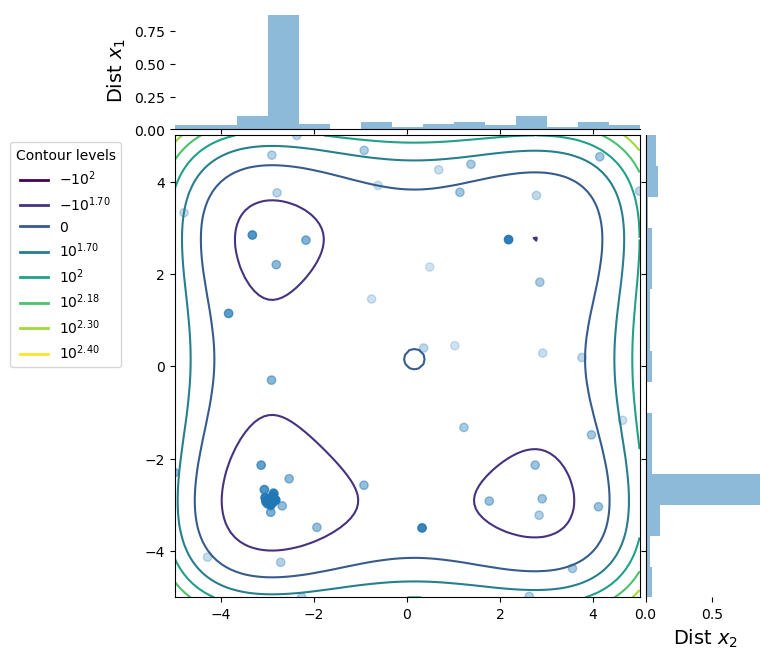

In [5]:
# put x_iters in two columns pandas dataframe
x_iters = np.array(all_results[0].x_iters)
x_iters_df = pd.DataFrame(x_iters, columns=['x', 'y'])

# Create main 2D scatter plot
f, ax = plt.subplots(figsize=(6, 6))

# Create an alpha array between 0.2 and 1 based on the order of points
# This creates a gradient of points from light to dark (first to last)
n = len(x_iters_df["x"])
start = 0.2
stop = 1
alpha_array = np.linspace(start, stop, n)

ax.scatter(x_iters_df["x"], x_iters_df["y"], alpha=alpha_array)


# plot contour
xl, xu = func.bounds[0]
yl, yu = func.bounds[1]

x = np.linspace(xl, xu, 100)
y = np.linspace(yl, yu, 100)

x_ax, y_ax = np.meshgrid(x, y)

vals = np.c_[x_ax.ravel(), y_ax.ravel()]
z_ax = np.reshape([styblinski(val) for val in vals], (100, 100))

# Generate contour plot
contour_set = ax.contour(x_ax, y_ax, z_ax)

# Create legend manually
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
contour_labels = [fmt(x) for x in contour_set.levels]

# Creating a list of Line2D objects to set in the legend
lines = [Line2D([0], [0], color=line.get_edgecolor(), linewidth=2)
        for line in contour_set.collections]

# Adding legend manually
ax.legend(lines, contour_labels, title="Contour levels",
          bbox_to_anchor=(-0.1, 1), loc='upper right')

# Create a new axes for the x marginal histogram with the same x axis
ax_x_hist = f.add_axes([ax.get_position().x0,
                        ax.get_position().y0 + ax.get_position().height + 0.01,
                        ax.get_position().width, 0.2], sharex=ax)
ax_x_hist.hist(x_iters_df["x"], bins=15, density=True, alpha=0.5)
ax_x_hist.get_yaxis().set_tick_params(which='both', direction='out')
sns.despine(ax=ax_x_hist, left=True)  # Remove left spine
ax_x_hist.set_ylabel(r"Dist $x_1$", fontsize = 14)  # Set the label for the x marginal histogram

# Create a new axes for the y marginal histogram with the same y axis
ax_y_hist = f.add_axes([ax.get_position().x0 + ax.get_position().width + 0.01,
                        ax.get_position().y0, 0.2,
                        ax.get_position().height], sharey=ax)
ax_y_hist.hist(x_iters_df["y"], bins=15, density=True, orientation='horizontal', alpha=0.5)
ax_y_hist.get_xaxis().set_tick_params(which='both', direction='out')
sns.despine(ax=ax_y_hist, bottom=True)  # Remove bottom spine
ax_y_hist.set_xlabel(r"Dist $x_2$", fontsize = 14)  # Set the label for the y marginal histogram

# Hide redundant tick labels
plt.setp(ax_x_hist.get_xticklabels(), visible=False)
plt.setp(ax_y_hist.get_yticklabels(), visible=False)

plt.show()

In [6]:
all_results[0].x_iters

[[0.48813503927324753, 2.1518936637241945],
 [1.0276337607164387, 0.44883182996896864],
 [-0.7634520066109529, 1.4589411306665612],
 [-0.6241278873730749, 3.9177300078207975],
 [4.636627605010292, -1.165584811742223],
 [2.917250380826646, 0.2889491975290448],
 [0.6804456109393231, 4.25596638292661],
 [-4.28963941802113, -4.1287070029845925],
 [-4.797816025596743, 3.3261984554793798],
 [2.7815675094985046, 3.7001214824681914],
 [0.357391349895984, 0.3980889826041265],
 [3.761199198871509, 0.1926491575004654],
 [-2.7963433913244105, 3.7578609139574226],
 [5.0, 3.795210986543987],
 [-2.263173297238829, -5.0],
 [-2.370323273130053, 5.0],
 [-2.907174019117171, 4.572768305466699],
 [-2.716460993958488, -4.240537068476339],
 [2.6281070183914634, -4.978365309227151],
 [2.840107102806771, -3.2209576197464678],
 [-0.922327051412017, 4.676941045047894],
 [2.855789468097022, 1.823707064892087],
 [1.2227392037827691, -1.320534958623774],
 [1.3736724396849587, 4.37599972171885],
 [3.557074667734849,